<a href="https://colab.research.google.com/github/happylittle7/TAICA_Generative-AI-Text-and-Image-Synthesis-Principles-and-Practice/blob/main/NTNU_41247032S_%E8%B3%87%E5%B7%A5116_%E5%90%B3%E4%BF%8A%E5%BB%B7_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI美食製作助手
這個專案結合本學期學到的所有技巧，使用者只要提供有關食物的靈感，AI就可以自動發明一道菜，並且產生製作的方式、營養價值，以及食物的圖片。

首先先安裝必要的套件

In [ ]:
!pip install aisuite[all]

接著登入HuggingFace

In [ ]:
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HuggingFace')
login(token=hf_token)

再來import會用到的套件

In [ ]:
from diffusers import StableDiffusionPipeline, StableAudioPipeline
from openai import OpenAI

import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random
import os
import aisuite as ai

import soundfile as sf

## Text to text: 依據使用者的想法發明餐點！

首先，我們要先能將使用者的想法來生成歌詞，這部分我打算利用Groq上的llama4模型

先將Groq的API金鑰存起來

In [ ]:
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key

指定模型

In [ ]:
provider = "groq"
model = "llama-4-scout-17b-16e-instruct"

設定標準回應函式

In [ ]:
def generateFood(
        system="""
        你是專業的廚師，我現在會給你他一道新菜色的靈感，請為其發明一道菜，請直接以繁體中文回傳餐點名稱、是怎麼想到產生這道料理的原因（發明動機）及製作方式就好，不需要任何多餘的字元。

        請謹守以下事項：
        1.僅使用繁體中文
        2.步驟越詳細越好

        請以下列格式回傳：
        餐點名稱：
        發明動機：
        製作方式：
        """,
        prompt="Hi",
        provider="groq",
        model="llama3-70b-8192"
        ):

  client = ai.Client()

  messages = [
      {"role": "system", "content": system},
      {"role": "user", "content": prompt}
  ]

  response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)


  return response.choices[0].message.content

In [ ]:
## Debug
generateFood(prompt="甜甜的東西，要有牛肉")

## Text to text: 將使用者發明的餐點轉換成生圖的prompt

In [ ]:
def generateFoodPrompt(
        system="""
        「請使用英文回答」
        你是AI生圖的專家，我現在會給你一道新菜色的名稱和製作方式，請為其發明一道菜，並回傳用來生成那道菜圖片的prompt，請直接回傳prompt，不要傳任何無關的文字。請按照以下格式：


        """,
        prompt="Hi",
        provider="groq",
        model="llama3-70b-8192"
        ):

  client = ai.Client()

  messages = [
      {"role": "system", "content": system},
      {"role": "user", "content": prompt}
  ]

  response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)


  return response.choices[0].message.content

In [ ]:
generateFoodPrompt(prompt="""
餐點名稱：蜜海珍珠

製作方式：

1. 海鹽拌入法國松露菌中，讓其充分吸收海鹽的味道。
2. 蜜糖拌入法國松露菌，讓其充分吸收蜜糖的甜度。
3. 搭配新鮮的鮑魚，將鮑魚切成細珠狀，然後用法國松露菌和蜜糖將鮑魚珠包裹起來。
4. 最後將其放在一個小小的貝殼中，並配上一些新鮮的海草，讓其充分顯示出海的氣息。

""")

## Text to text: 分析餐點的營養價值


In [ ]:
def generateFoodNutrition(
        system="""
        你是專業的營養師，我現在會給你他一道菜色、創作動機和製作方式，請分析這道菜，並且產生一篇分析這道菜的雜誌文章。

        請謹守以下事項：
        1.僅能使用繁體中文

        """,
        prompt="Hi",
        provider="groq",
        model="llama3-70b-8192"
        ):

  client = ai.Client()

  messages = [
      {"role": "system", "content": system},
      {"role": "user", "content": prompt}
  ]

  response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)


  return response.choices[0].message.content

In [ ]:
generateFoodNutrition(prompt="""
餐點名稱：蜜海珍珠

製作方式：

1. 海鹽拌入法國松露菌中，讓其充分吸收海鹽的味道。
2. 蜜糖拌入法國松露菌，讓其充分吸收蜜糖的甜度。
3. 搭配新鮮的鮑魚，將鮑魚切成細珠狀，然後用法國松露菌和蜜糖將鮑魚珠包裹起來。
4. 最後將其放在一個小小的貝殼中，並配上一些新鮮的海草，讓其充分顯示出海的氣息。
""")

## Text to image: 將使用者的想法轉成圖片！

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    "digiplay/Photon_v1",
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

In [ ]:
def generate_image(prompt):

    seed = random.randint(0, 2**32)

    generator = torch.Generator("cuda").manual_seed(seed)
    image = pipe(prompt=prompt,
                 generator=generator).images[0]
    return image

In [ ]:
#debug
generate_image("A delicate, intricately designed dish with a small, shimmering pearl of abalone, coated in a layer of caramelized French truffle and honey, nestled in a tiny seashell surrounded by a sprinkle of fresh seaweed, glistening with dew and evoking the freshness of the ocean.")

## 整合所有指令

In [ ]:
def generateFoodFromGradio(user_input):
  food_description = generateFood(prompt=user_input)
  food_prompt = generateFoodPrompt(food_description)
  food_nutrition = generateFoodNutrition(prompt=food_description)
  return food_description, food_nutrition, generate_image(food_prompt)


In [ ]:
generateFoodFromGradio("甜甜的東西，要有牛肉，而且要有海的味道")

## 生成Gradio介面

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

In [ ]:
with gr.Blocks(gr.themes.Citrus() ) as demo:
  gr.Markdown("# 😎AI餐點發明助手")
  with gr.Row():
    with gr.Column():


      user_input = gr.Textbox(label="想品嚐怎麼樣的美食！",info="ex: 「甜甜的東西，要有牛肉！還要有海的味道，希望有便當的香氣」")
      btn = gr.Button("幫我發明美食！")

      out1 = gr.Textbox(label="🧠 ai為你發明的餐點")

    with gr.Column():
      food_image = gr.Image(type="pil",label="美食照片")
      food_nutrition = gr.Textbox(label="分析餐點的營養價值")


  btn.click(generateFoodFromGradio, inputs=[user_input], outputs=[out1, food_nutrition, food_image])


In [ ]:
demo.launch(share=True, debug=True)

## 報告說明

### 一、使用的模型
這次期末專案一共使用下列兩個模型：
1.   Llama 3
    

*   主要用來執行Text to text文字生文字的任務。

*   負責將使用者的靈感轉換成料理名稱與製作方式、生圖片的Prompt以及營養價值。


2.   digiplay/Photon_v1


*   主要用來執行Text to image文字生圖片的任務。

*   負責將生圖片的Prompt轉換成圖片。

### 二、功能


1.   功能一：自動依據使用者靈感產生符合要求的菜品
2.   功能二：能將產生出的菜品自動再丟一次給AI請他產生生圖的Prompt
3.   功能三：能自動根據前面產生的Prompt生成餐點圖片


### 三、成果展示
請依序執行notebook裡的程式，請注意要先申請好Groq和HuggingFace的API，將他們先匯入到colab的Groq和HuggingFace欄位中。

這次期末專案我覺得做得很成功，能一件自動看到腦袋想吃的東西完整呈現出來非常實用。這套系統不僅可以滿足一般使用者。未來開餐廳的廚師要發明新菜色時也可以使用。


### 截圖

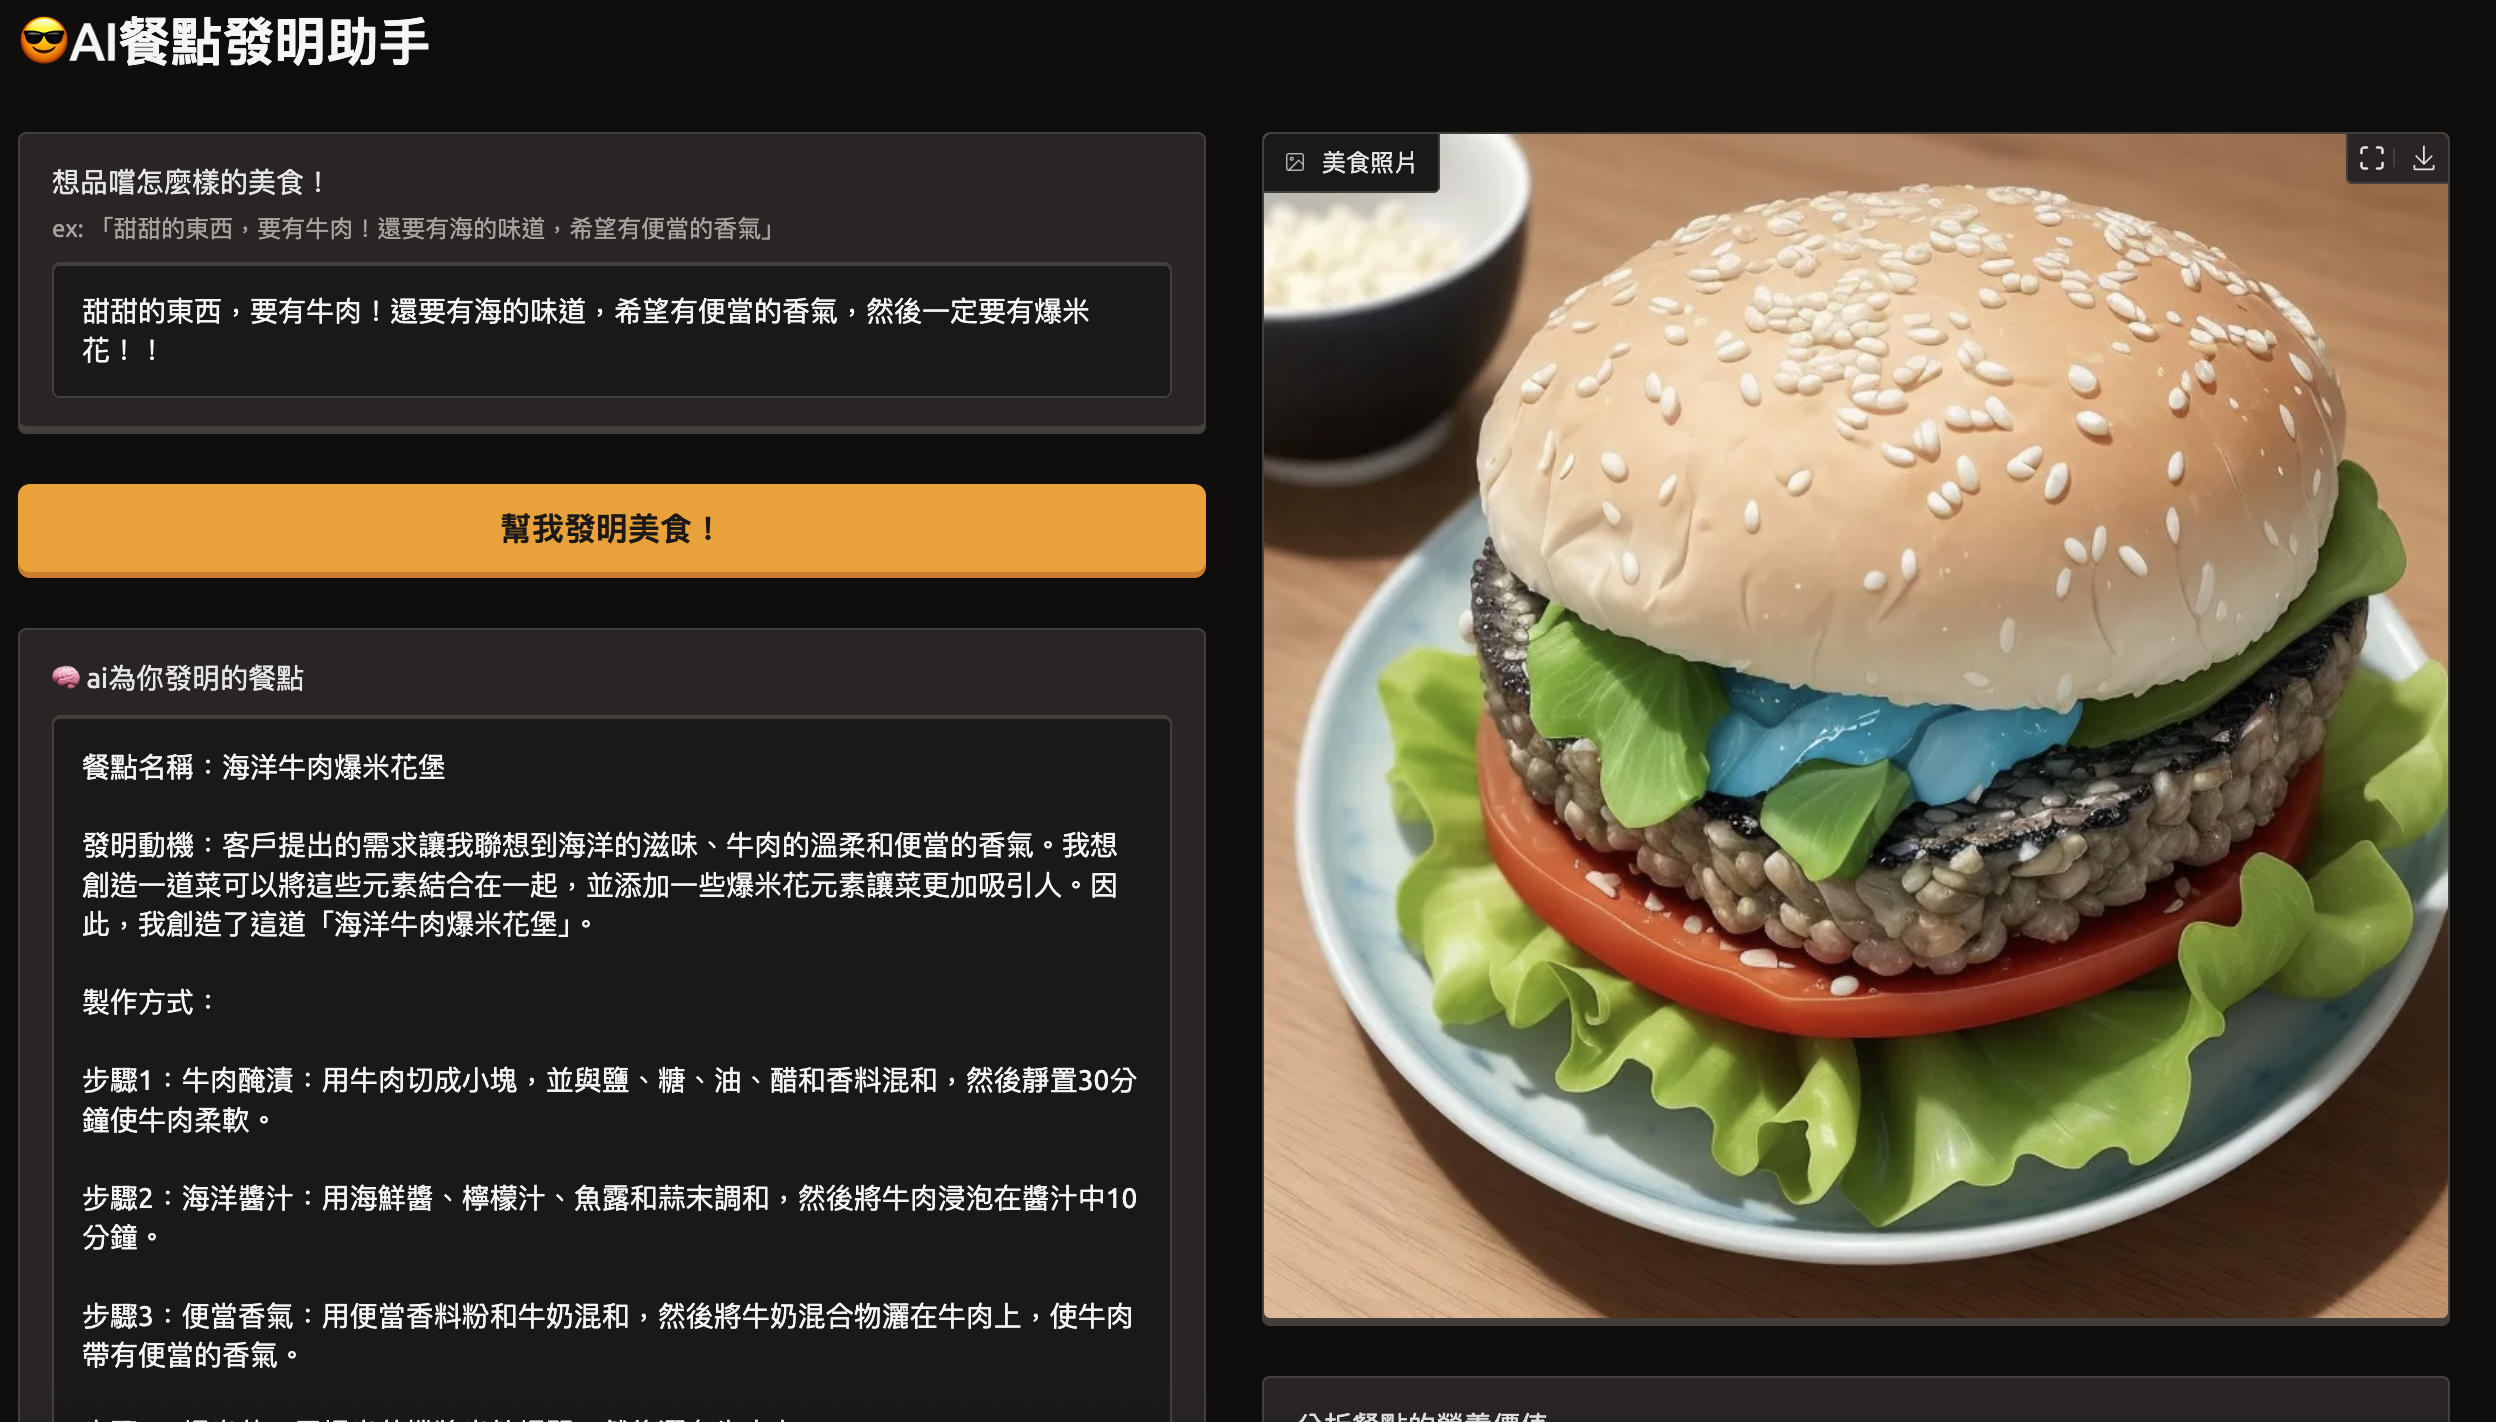